In [1]:
import time
import numpy as np
import torch

from sbi import utils as utils
from cost_aware_snpe_c import CostAwareSNPE_C
from sbi.inference.snpe.snpe_c import SNPE_C
from sbi.utils.torchutils import *
from sbi.utils import process_prior
from sbi.utils.user_input_checks import *
from simulators import bernoulli_sir

from hydra import compose, initialize
import hydra

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood

from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
def MMD_unweighted(x, y, lengthscale):
    """ Approximates the squared MMD between samples x_i ~ P and y_i ~ Q
    """

    m = x.shape[0]
    n = y.shape[0]

    z = torch.cat((x, y), dim=0)

    K = kernel_matrix(z, z, lengthscale)

    kxx = K[0:m, 0:m]
    kyy = K[m:(m + n), m:(m + n)]
    kxy = K[0:m, m:(m + n)]

    return (1 / m ** 2) * torch.sum(kxx) - (2 / (m * n)) * torch.sum(kxy) + (1 / n ** 2) * torch.sum(kyy)


def median_heuristic(y):
    a = torch.cdist(y, y)**2
    return torch.sqrt(torch.median(a / 2))


def kernel_matrix(x, y, l):
    d = torch.cdist(x, y)**2

    kernel = torch.exp(-(1 / (2 * l ** 2)) * d)

    return kernel

In [3]:
def calc_acc_prob(gp, likelihood, theta, prior_start, k):

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        cost = likelihood(model(theta)).mean

        lower_cost = likelihood(model(prior_start)).mean
    return (lower_cost ** k) / (cost**k)

class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [14]:
def c2st(
    X: torch.Tensor,
    Y: torch.Tensor,
    seed: int = 1,
    n_folds: int = 5,
    scoring: str = "accuracy",
    z_score: bool = True,
    noise_scale: Optional[float] = None,
) -> torch.Tensor:
    """Classifier-based 2-sample test returning accuracy

    Trains classifiers with N-fold cross-validation [1]. Scikit learn MLPClassifier are
    used, with 2 hidden layers of 10x dim each, where dim is the dimensionality of the
    samples X and Y.

    Args:
        X: Sample 1
        Y: Sample 2
        seed: Seed for sklearn
        n_folds: Number of folds
        z_score: Z-scoring using X
        noise_scale: If passed, will add Gaussian noise with std noise_scale to samples

    References:
        [1]: https://scikit-learn.org/stable/modules/cross_validation.html
    """
    if z_score:
        X_mean = torch.mean(X, dim=0)
        X_std = torch.std(X, dim=0)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std

    if noise_scale is not None:
        X += noise_scale * torch.randn(X.shape)
        Y += noise_scale * torch.randn(Y.shape)

    X = X.cpu().numpy()
    Y = Y.cpu().numpy()

    ndim = X.shape[1]

    clf = MLPClassifier(
        activation="relu",
        hidden_layer_sizes=(10 * ndim, 10 * ndim),
        max_iter=10000,
        solver="adam",
        random_state=seed,
    )

    data = np.concatenate((X, Y))
    target = np.concatenate(
        (
            np.zeros((X.shape[0],)),
            np.ones((Y.shape[0],)),
        )
    )

    shuffle = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    scores = cross_val_score(clf, data, target, cv=shuffle, scoring=scoring)

    scores = np.asarray(np.mean(scores)).astype(np.float32)
    return torch.from_numpy(np.atleast_1d(scores))

In [20]:
def compute_ks_scores(true_samples, estimated_samples):
    """
    Compute KS test scores between true and estimated posterior samples.
    
    Parameters:
    -----------
    true_samples : numpy.ndarray
        Samples from the true posterior, shape [n_samples, n_dim]
    estimated_samples : numpy.ndarray
        Samples from the estimated posterior, shape [n_samples, n_dim]
        
    Returns:
    --------
    list of floats
        KS test statistic for each dimension
    list of floats
        p-values for each KS test (optional, can be ignored for SBI evaluation)
    """
    
    n_dims = true_samples.shape[1]
    ks_stats = []
    
    # Compute KS test for each dimension
    for dim in range(n_dims):
        ks_stat, p_value = stats.ks_2samp(
            true_samples[:, dim],
            estimated_samples[:, dim]
        )
        ks_stats.append(ks_stat)

    return torch.tensor(ks_stats)

# Bernoulli SIR

In [4]:
bern_sir = bernoulli_sir.BernSIR()

## Data generation

In [ ]:
# DON'T NEED TO RUN AGAIN IF YOU ALREADY GENERATED THE REFERENCE DATA
N = 50000

bern_sir_theta_npe_large = bern_sir.sample_theta([N]).reshape(-1, bern_sir.theta_dim)
bern_sir_x_npe_large = torch.empty([N, bern_sir.x_dim])
for i in range(N):
    bern_sir_x_npe_large[i, :] = bern_sir(bern_sir_theta_npe_large[i])

# Observed data generation
bern_sir_obs_theta = torch.tensor([0.5, 0.5, 0.5])
bern_sir_obs_x = bern_sir(bern_sir_obs_theta)

torch.save(bern_sir_x_npe_large, "data/bern_sir_x_npe_large.pt")
torch.save(bern_sir_theta_npe_large, "data/bern_sir_theta_npe_large.pt")
torch.save(bern_sir_obs_x, "data/bern_sir_obs_x.pt")
torch.save(bern_sir_obs_theta, "data/bern_sir_obs_theta.pt")

## Data loading

In [7]:
bern_sir_x_npe_large = torch.load("data_/bern_sir_x_npe_large.pt")
bern_sir_theta_npe_large = torch.load("data_/bern_sir_theta_npe_large.pt")

bern_sir_obs_x = torch.load("data_/bern_sir_obs_x.pt")
bern_sir_obs_theta = torch.load("data_/bern_sir_obs_theta.pt")

## Fit GP

In [8]:
n_train_pair = 500 # number of pairs used to fit GP
n_rep = 20 # number of repeats to get the average cost

In [16]:
# simulate the cost
X = bern_sir_theta_npe_large[:n_train_pair]

times_train = torch.zeros(n_train_pair)

for i in range(n_train_pair):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(bern_sir_theta_npe_large[i])
    et = time.time()
    times_train[i] = (et - st) / n_rep

# save GP training samples
torch.save(X, "data/bern_sir_gp_x.pt")
torch.save(times_train, "data/bern_sir_gp_y.pt")

In [79]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)
model.float()
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X.float())
    loss = -mll(output, times_train)
    loss.backward()
    optimizer.step()
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item()}')


torch.save({'model_state_dict': model.state_dict(), 'likelihood_state_dict': likelihood.state_dict()}, 'data/bern_sir_gp.pth')

In [9]:
state_dicts = torch.load('data/bern_sir_gp.pth')  # Load GP params

# Load GP data
X = torch.load("data/bern_sir_gp_x.pt")
times_train = torch.load("data/bern_sir_gp_y.pt")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X, times_train, likelihood)

model.load_state_dict(state_dicts['model_state_dict'])
likelihood.load_state_dict(state_dicts['likelihood_state_dict'])

model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [8]:
N = 50
n_rep = 20

beta = torch.linspace(0.1, 1, N)
beta_fixed = 0.5

gamma_fixed = 0.5
gamma = torch.linspace(0.1, 1, N)

p = torch.linspace(0.1, 1, N)
p_fixed = 0.5

beta_combined = beta_fixed * torch.ones_like(beta)
gamma_combined = gamma_fixed * torch.ones_like(gamma)
p_combined = p_fixed * torch.ones_like(p)

combination_beta = torch.stack((beta, gamma_combined, p_combined), dim=1)
combination_gamma = torch.stack((beta_combined, gamma, p_combined), dim=1)
combination_p = torch.stack((beta_combined, gamma_combined, p), dim=1)

In [59]:
times_vs_beta = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_beta[i])
    et = time.time()
    times_vs_beta[i] = (et - st) / n_rep

times_vs_gamma = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_gamma[i])
    et = time.time()
    times_vs_gamma[i] = (et - st) / n_rep

times_vs_p = torch.zeros(N)
for i in range(N):
    st = time.time()
    for _ in range(n_rep):
        result = bern_sir(combination_p[i])
    et = time.time()
    times_vs_p[i] = (et - st) / n_rep

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_beta = likelihood(model(combination_beta)).mean
    observed_pred_gamma = likelihood(model(combination_gamma)).mean
    observed_pred_p = likelihood(model(combination_p)).mean    

In [62]:
torch.save(times_vs_beta, "data/bern_cost_beta.pt")
torch.save(times_vs_gamma, "data/bern_cost_gamma.pt")
torch.save(times_vs_p, "data/bern_cost_p.pt")

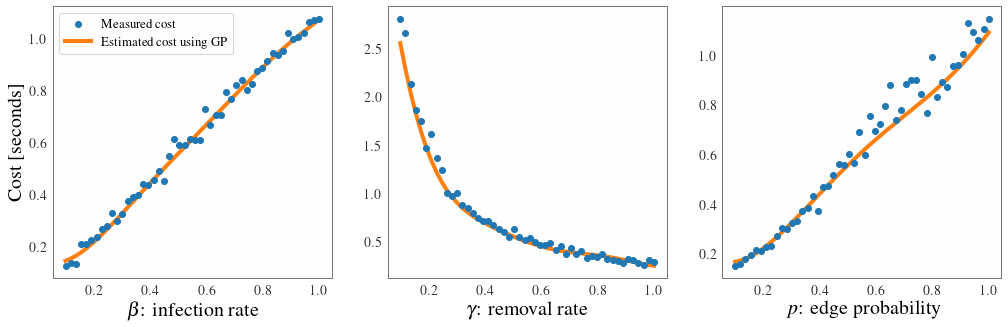

In [63]:
times_vs_beta = torch.load("data/bern_cost_beta.pt")
times_vs_gamma = torch.load("data/bern_cost_gamma.pt")
times_vs_p = torch.load("data/bern_cost_p.pt")

plt.figure(figsize=[17,5])

plt.subplot(1, 3, 1)
plt.scatter(beta, times_vs_beta, label="Measured cost")
plt.plot(gamma, observed_pred_beta, color="C1", linewidth=4, zorder=0, label="Estimated cost using GP")
plt.xlabel("$\\beta$: infection rate", fontsize=20)
plt.ylabel("Cost [seconds]", fontsize=20)
plt.legend(fontsize=13)

plt.subplot(1, 3, 2)
plt.scatter(gamma, times_vs_gamma)
plt.plot(gamma, observed_pred_gamma, color="C1", linewidth=4, zorder=0, label="Estimated cost using GP")
plt.xlabel("$\\gamma$: removal rate", fontsize=20)

plt.subplot(1, 3, 3)
plt.scatter(p, times_vs_p)
plt.plot(gamma, observed_pred_p, color="C1", linewidth=4, zorder=0, label="Estimated cost using GP")
plt.xlabel("$p$: edge probability", fontsize=20)

plt.savefig("figures/plot_cost_bern_sir.pdf")
plt.show()

In [64]:
prior_start = torch.tensor([0.1, 1.0, 0.1]).reshape(-1, 3)
prior_end = torch.tensor([1., 0.1, 1.0]).reshape(-1, 3)

g_min = likelihood(model(prior_start)).mean / 10
g_max = likelihood(model(prior_end)).mean / 10

print("g_min with k=0.5: ", (g_min ** 0.5).item())
print("g_min with k=1: ", (g_min ** 1).item())
print("g_min with k=2: ", (g_min ** 2).item())

print("g_max with k=0.5: ", (g_max ** 0.5).item())
print("g_max with k=1: ", (g_max ** 1).item())
print("g_max with k=2: ", (g_max ** 2).item())

g_min with k=0.5:  0.11970391869544983
g_min with k=1:  0.014329028315842152
g_min with k=2:  0.00020532104826997966
g_max with k=0.5:  0.9190499782562256
g_max with k=1:  0.8446528315544128
g_max with k=2:  0.7134383916854858


In [68]:
k = 2

num_sim = 1000
theta_tilde = torch.zeros([num_sim, 3])
count = 0
while count < num_sim:
    theta = bern_sir.sample_theta([1]).reshape(-1, 3)
    if calc_acc_prob(model, likelihood, theta, prior_start, k) > torch.rand(1):
        theta_tilde[count] = theta.reshape(-1)
        count += 1

w = likelihood(model(theta_tilde)).mean.detach() ** k

theta_prior = bern_sir.sample_theta([1000]).reshape(-1, 3)

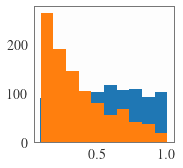

In [69]:
plt.hist(theta_prior.detach().numpy()[:, 0], bins=10)
plt.hist(theta_tilde.detach().numpy()[:, 0], bins=10)
plt.show()

## CEG ESS

In [22]:
num_sim = 10000
num_repeats = 2
k = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]) # Exponent of the penaly function g(z) = z^k

prior_start = torch.tensor([0.1, 1.0, 0.1]).reshape(-1, 3)

ess_cost_aware = np.zeros([k.size, num_repeats])
ceg = np.zeros([k.size, num_repeats])

for ind in range(k.size):
    for j in range(num_repeats):
        
        if ind == 0:
            theta = bern_sir.sample_theta([num_sim])
            ess_cost_aware[ind, j] = 1
            ceg[ind, j] = 1
        else:
            # Sampling from cost-modified prior
            theta_tilde = torch.zeros([num_sim, 3])
            count = 0
            while count < num_sim:
                param_value = bern_sir.sample_theta([1]).reshape(-1, 3)
                if calc_acc_prob(model, likelihood, param_value, prior_start, k[ind]) > torch.rand(1):
                    theta_tilde[count] = param_value.reshape(-1)
                    count += 1

            w_u = likelihood(model(theta_tilde)).mean.detach() ** k[ind]   #self-normalised importance weights
            
            # Compute CEG
            ceg[ind, j] = torch.mean(likelihood(model(theta)).mean.detach()) / torch.mean(likelihood(model(theta_tilde)).mean.detach())
            # Compute ESS
            ess_cost_aware[ind, j] = ((w_u.sum())**2 / torch.square(w_u).sum()) / num_sim
            
print(ess_cost_aware * ceg)

## Train reference NPE

In [41]:
# DON'T NEED TO RUN
bern_sir_inference_npe_large = SNPE_C()
bern_sir_nn_npe_large = bern_sir_inference_npe_large.append_simulations(
    bern_sir_theta_npe_large, bern_sir_x_npe_large).train()

prior, *_ = process_prior(bern_sir.prior)
bern_sir_post_npe_large = bern_sir_inference_npe_large.build_posterior(bern_sir_nn_npe_large, prior=prior)
bern_sir_samples_npe_large = bern_sir_post_npe_large.sample((1000,), x=bern_sir_obs_x)

torch.save(bern_sir_samples_npe_large, "data/bern_sir_post_reference.pt")

In [11]:
bern_sir_post_reference = torch.load("data_/bern_sir_post_reference.pt")

# Statistics over multiple runs

In [15]:
# C2ST - NPE
n_run = 50
c2st_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 3])

for i in range(n_run):
    checkpoint_path = f"sims/bern_sir/1.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)

    c2st_npe[i] = c2st(bern_sir_post_reference, posterior_samples_npe[i])

c2st_npe = c2st_npe.detach().numpy() 
c2st_npe_mean = np.mean(c2st_npe)
c2st_npe_std = np.std(c2st_npe)

print(f"NPE c2st mean {c2st_npe_mean:.2f} (std {c2st_npe_std:.2f})")

NPE c2st mean 0.93 (std 0.01)


In [16]:
# C2ST
def get_c2st_results(k, n_run):
    n_run = 50
    c2st_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 3])
    
    for i in range(n_run):
        checkpoint_path = f"sims/bern_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
        posterior_canpe = checkpoint["posterior_canpe"]
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
    
        c2st_canpe[i] = c2st(bern_sir_post_reference, posterior_samples_canpe[i])
    
    c2st_canpe = c2st_canpe.detach().numpy() 
    c2st_canpe_mean = np.mean(c2st_canpe)
    c2st_canpe_std = np.std(c2st_canpe)
    
    print(f"CA-NPE c2st mean {c2st_canpe_mean:.2f} (std {c2st_canpe_std:.2f})")

In [17]:
get_c2st_results("0.5", 50)
get_c2st_results("1.0", 50)
get_c2st_results("2.0", 50)
get_c2st_results("mixture", 50)

CA-NPE c2st mean 0.93 (std 0.01)
CA-NPE c2st mean 0.93 (std 0.01)
CA-NPE c2st mean 0.92 (std 0.02)
CA-NPE c2st mean 0.92 (std 0.02)


### ks test

In [21]:
# KS - NPE
n_run = 50
ks_npe = torch.zeros([n_run, 3])
posterior_samples_npe = torch.zeros([n_run, 1000, 3])

for i in range(n_run):
    checkpoint_path = f"sims/bern_sir/1.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)

    ks_npe[i] = compute_ks_scores(bern_sir_post_reference, posterior_samples_npe[i])

ks_npe = ks_npe.detach().numpy() 
ks_npe_mean = np.mean(ks_npe, axis=0)
ks_npe_std = np.std(ks_npe, axis=0)

print(f"NPE ks score mean {ks_npe_mean} (std {ks_npe_std})")

NPE ks score mean [0.11816001 0.06188    0.08400001] (std [0.03075345 0.02591034 0.02869913])


In [22]:
def get_ks_results(k, n_run):
    n_run = 50
    ks_canpe = torch.zeros([n_run, 3])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 3])
    
    for i in range(n_run):
        checkpoint_path = f"sims/bern_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    
        posterior_canpe = checkpoint["posterior_canpe"]
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)

        ks_canpe[i] = compute_ks_scores(bern_sir_post_reference, posterior_samples_canpe[i])
    
    ks_canpe = ks_canpe.detach().numpy() 
    ks_canpe_mean = np.mean(ks_canpe, axis=0)
    ks_canpe_std = np.std(ks_canpe, axis=0)
    
    print(f"CA-NPE ks mean {ks_canpe_mean} (std {ks_canpe_std})")

In [23]:
get_ks_results("0.5", 50)
get_ks_results("1.0", 50)
get_ks_results("2.0", 50)
get_ks_results("mixture", 50)

CA-NPE ks mean [0.12770002 0.048      0.09043999] (std [0.02566418 0.0157886  0.02483881])
CA-NPE ks mean [0.14102    0.06744001 0.09206   ] (std [0.02897067 0.02584118 0.02835166])
CA-NPE ks mean [0.15186    0.12976003 0.11748   ] (std [0.03002    0.03458009 0.03562709])
CA-NPE ks mean [0.11929999 0.04876    0.0961    ] (std [0.03400367 0.01693229 0.0360118 ])


In [12]:
# NPE results

n_run = 50
mmd_npe = torch.zeros([n_run])
posterior_samples_npe = torch.zeros([n_run, 1000, 3])
cost_npe = torch.zeros([n_run])

for i in range(n_run):
    checkpoint_path = f"sims/bern_sir/1.0/{i+1}/ckpt.tar"
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    posterior_npe = checkpoint["posterior_npe"]
    posterior_samples_npe[i] = posterior_npe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
    
    mmd_npe[i] = MMD_unweighted(posterior_samples_npe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))

mmd_npe = mmd_npe.detach().numpy() 
mmd_npe_mean = np.mean(mmd_npe)
mmd_npe_std = np.std(mmd_npe)

print(f"NPE MMD mean {mmd_npe_mean:.2f} (std {mmd_npe_std:.2f})")

NPE MMD mean 0.02 (std 0.00)


In [12]:
median_heuristic(bern_sir_post_reference)

tensor(0.3235)

In [9]:
def get_results(k, n_run):

    mmd_canpe = torch.zeros([n_run])
    posterior_samples_canpe = torch.zeros([n_run, 1000, 3])
    cost_canpe = torch.zeros([n_run])
    cost_saved = torch.zeros([n_run])
    
    for i in range(n_run):
        checkpoint_path = f"sims/bern_sir/{k}/{i+1}/ckpt.tar"
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        posterior_canpe = checkpoint["posterior_canpe"]
        
        posterior_samples_canpe[i] = posterior_canpe.sample((1000,), x=bern_sir_obs_x, show_progress_bars=False)
        
        mmd_canpe[i] = MMD_unweighted(posterior_samples_canpe[i], bern_sir_post_reference, lengthscale=median_heuristic(bern_sir_post_reference))
        cost_npe[i] = torch.tensor(checkpoint["cost_npe"])
        cost_canpe[i] = torch.tensor(checkpoint["cost_canpe"])
        cost_saved[i] = 1 - cost_canpe[i] / cost_npe[i]
    
    mmd_canpe = mmd_canpe.detach().numpy() 
    mmd_canpe_mean = np.mean(mmd_canpe)
    mmd_canpe_std = np.std(mmd_canpe)
    
    cost_canpe = cost_canpe.detach().numpy() 
    cost_canpe_mean = np.mean(cost_canpe)
    cost_canpe_std = np.std(cost_canpe)

    cost_saved = cost_saved.detach().numpy()
    cost_saved_mean = np.mean(cost_saved)
    cost_saved_std = np.std(cost_saved)
    
    print(f"CA-NPE MMD mean {mmd_canpe_mean:.2f} (std {mmd_canpe_std:.2f})")
    # print(f"CA-NPE cost mean {cost_canpe_mean:.2f} (std {cost_canpe_std:.2f})")
    print(f"Cost saved: {cost_saved_mean:.2f}(std {cost_saved_std:.2f})")

In [13]:
get_results('0.5', 50)

CA-NPE MMD mean 0.02 (std 0.00)
Cost saved: 0.24(std 0.05)


In [14]:
get_results('1.0', 50)

CA-NPE MMD mean 0.02 (std 0.01)
Cost saved: 0.37(std 0.04)


In [15]:
get_results('2.0', 50)

CA-NPE MMD mean 0.04 (std 0.01)
Cost saved: 0.47(std 0.03)


In [ ]:
get_results('mixture', 50)

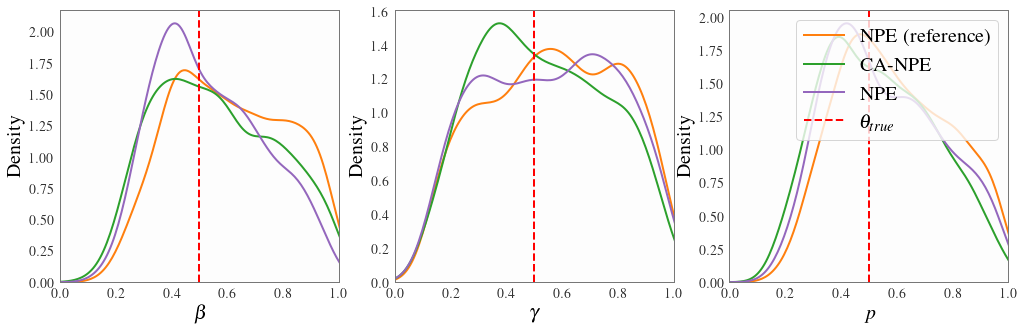

In [17]:
seed = 1
plt.figure(figsize=[17,5])
plt.subplot(1, 3, 1)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,0], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,0], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,0], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[0], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')

plt.xlabel("$\\beta$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.subplot(1, 3, 2)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,1], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,1], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,1], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[1], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.xlabel("$\\gamma$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.subplot(1, 3, 3)
plt.xlim(0, 1)
sns.kdeplot(bern_sir_post_reference[:,2], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE (reference)")
sns.kdeplot(posterior_samples_canpe[seed,:,2], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
sns.kdeplot(posterior_samples_npe[seed,:,2], color = "C4", linewidth = 2, linestyle = "solid", label = "NPE")
plt.axvline(x=bern_sir_obs_theta.detach().numpy()[2], color='r', linestyle='--', linewidth=2, label='$\\theta_{true}$')
plt.legend(fontsize=20, loc=1)
plt.xlabel("$p$", fontsize = 20)
plt.ylabel("Density", fontsize=20)

plt.show()